Este script abre varios ficheros netCDF, lee una variable OCEANIQUE y despues selectionamos las estaciones del anio, calculo de medias estacionales, de anuales y hacemos un indice sobre un dominio, con masqueado y sin masqueado. Il y a un boucle pour faire le calcul dans plusieurs basins.

## Choose the kernel env_emis_gloenv39 (already created by ES)

### Add this environment to your jupyter kernel 

./installa_env39.sh

close and reopen the notebook to see the new kernel env_emis_gloenv39 and use it

### Delete the environment from your jupyter kernel
jupyter kernelspec list

jupyter kernelspec uninstall env_emis_gloenv39

In [1]:
# import xarray, numpy and pandas 
import xarray as xr
import numpy as np
import pandas as pd

import time as tm

from pylab import *

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker

import seaborn as sns

# import plotting modules 
from matplotlib.colors import BoundaryNorm
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.path as mpath

from cartopy import config
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


%matplotlib inline

/data/softs/anaconda3-2020.07/envs/gloenv_py3.9/lib/python3.9/site-packages/pyproj/__init__.py:91: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_LIB or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


In [2]:
## Parametres d'entree

varname = 'tos'   #'tos'
vartype = 'Omon' #! La variable nommée 'type' existe déjà dans Python, on ne souhaite pas la modifier.
model = 'CNRM-ESM2-1'
expe = 'historical' 
grid = 'gn'

fyear_in = 1850
lyear_in = 2014

fyear_out=1960 #periode de traitement pour les donnees
lyear_out=2014

# Domaine spatial
basins = ["glo","glo30","atl30","pac30","ind30","ant","NINO34","ATL3"]
nbasins=len(basins)

#Mask file
infile_msk = "/data/scratch/globc/dcom/CMIP6_TOOLS/xESMF_Interpolation/masks_eorca1.nc"

#Input
indir = '/data/scratch/globc/dcom/CMIP6/CMIP/CNRM-CERFACS/'+model+'/'+expe+'/r*/'+vartype+'/'+varname+'/'+grid+'/latest/'
infile = varname+'_*'

In [3]:
# -- Lecture de la variable
ds = xr.open_mfdataset(indir+infile,engine='netcdf4', concat_dim='ensemble', combine='nested', chunks={'time': 1980})
#ds.info() #youpiiii!
fld = ds[varname]
# -- On selectionne une periode de temps pour le calcul
fld_sel = fld.sel(time=slice(str(fyear_out)+'-01-01', str(lyear_out)+'-12-31'))

In [4]:
def mask_field(data, mask = None):
    _mask = mask
    return data.where(_mask == 1.)

glo
glo30
atl30
pac30
ind30
ant
NINO34
ATL3


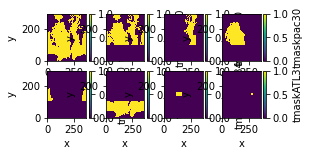

In [5]:
# - CALCUL (loop on basin) !!!!!
fig1 = plt.figure(figsize=(4,4))
#fig2 = plt.figure(figsize=(4,4))
outdir ='/data/scratch/globc/coquart/DATA_FOR_COMMON_JUPYTER_NOTEBOOKS/'
for ib in range(nbasins):
    outfile = varname+'_index_'+model+'_'+expe+'_'+str(fyear_out)+'_'+str(lyear_out)+'_'+basins[ib]+'.nc'
    name_basin=basins[ib]
    print(name_basin)
    # -- Lecture masques et facteurs d'echelle NEMO
    ds_msk= xr.open_mfdataset(infile_msk)
    tmask_2d_dom = ds_msk["tmask"+name_basin]
    e1t = ds_msk["e1t"]
    e2t = ds_msk["e2t"]
    # -- Calcul de l'area
    area = e1t[0] * e2t[0]
    ax1 = fig1.add_subplot(4,4,ib+1)
    ax1 = tmask_2d_dom.plot()
    # -- On masque et on selectionne la region d'etude
    fld_msk = mask_field(fld_sel, mask=tmask_2d_dom)
    area_msk = mask_field(area,mask=tmask_2d_dom)
    #ax = area_msk.plot() # Ca marche!!
    index = fld_msk.weighted(area_msk.fillna(0.)).mean(dim=('x', 'y'))
    # - Moyenne ensemble indice
    index_em=index.mean(dim='ensemble').compute()
    #ax2 = fig2.add_subplot(4,4,ib+1)
    #ax2 = index_em.plot()
    ## - On garde tout dans un fichier netCDF
    ds = xr.Dataset({'index': (("member","time"),index.values)},
                attrs = {
                    'creation_date': tm.strftime('%d/%m/%Y'),
                    'script_name': 'compute_indice2d_ensemble_ocean.ipynb',
                })
    
    output  = outdir + outfile
    ds.to_netcdf(output)